In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read timings

In [3]:
steptimes = pd.read_csv('../data/restartable/AllStepTimes', sep=' ', names='case n time'.split())
fsizes = pd.read_csv('../data/restartable/WfuFileSizes', sep='\s+', names='case fsize'.split())

In [10]:
pred1 = pd.read_csv('../data/restartable/GO1_nfchl_cpu_to_wall.txt', sep=' ', names='case time pred1'.split())
pred1.loc[pred1.pred1 < 0, 'pred1'] = pred1[pred1.pred1 > 0].median()['pred1']
pred2 = pd.read_csv('../data/restartable/GO2_nfchl_cpu_to_wall.txt', sep=' ', names='case time pred2'.split())
pred2.loc[pred2.pred2 < 0, 'pred2'] = pred2[pred2.pred2 > 0].median()['pred2']
pred2.case = pred2.case.str.replace('.xyz2_ang', '')

In [11]:
q = pd.merge(steptimes, fsizes, how='left')
assert set(np.isnan(q.fsize.values)) == set((False,)) # fsize complete
qq = pd.merge(q, pred1, how='left', on='case')
#assert (qq[qq.n == 1].time_x == qq[qq.n == 1].time_y).values.all() # Heinis times equal to Max' times
q = qq
del q['time_y']
qq = pd.merge(q, pred2, how='left', on='case')
#assert (qq[qq.n == 2].time_x == qq[qq.n == 2].time).values.all() # Heinis times equal to Max' times
del qq['time']
qq.columns = 'case n time fsize step1 step2'.split()
df = qq.copy()
df = df.dropna(how='any')

## placement

In [12]:
def simple(df, limit, diskMBps, jobQTime, jobOverhead):
    """ Submit jobs as is, one job per molecule, restart until converged. Fallback to 1day queue if one step does not fit. """
    fallback = 24*60*60
    
    # random order
    molecules = df.case.unique().copy()
    np.random.shuffle(molecules)
    
    # estimate packages
    walltime = 0
    cputime = 0
    
    upgraded = 0
    for molecule in molecules:
        s = df.query('case == @molecule').sort_values('n')
        
        # initialise walltime limit with target limit
        moleculelimit = limit
        
        remaining = moleculelimit
        stepsinjob = 0
        for idx, gostep in s.iterrows():
            assert(remaining > 0)
            if gostep.time <= remaining:
                remaining -= gostep.time
                stepsinjob += 1
            else:
                cputime += moleculelimit
                walltime += moleculelimit + jobOverhead + jobQTime
                remaining = moleculelimit - gostep.time
                if gostep.n != 1:
                    remaining -= gostep.fsize / diskMBps
                
                if remaining < 0:
                    assert (moleculelimit != fallback) # otherwise, 1day is too short for longest GO step
                    # run would not fit into current limit
                    remaining += (fallback - limit)
                    if stepsinjob > 1:
                        cputime += moleculelimit
                        walltime += moleculelimit + jobOverhead + jobQTime
                    moleculelimit = fallback
                stepsinjob = 1
                    
        cputime += (moleculelimit - remaining)
        walltime += (moleculelimit - remaining) + jobOverhead + jobQTime
        if moleculelimit == fallback:
            upgraded += 1
    if upgraded / len(molecules) > 0.25:
        raise ValueError('Too many upgrades: %d from %d' % (upgraded, len(molecules)))
    return cputime, walltime
    
simple(df, 1*60*60, 100, 60*60, 30)

(3529262.8850000002, 6832562.884999999)

In [13]:
def ml(df, limit, diskMBps, jobQTime, jobOverhead):
    """ Use 2nd step pred to estimate continuation. """
    fallback = 24*60*60
    
    # order by largest first step
    molecules = df.copy().sort_values('step1').case.unique()
    
    # estimate packages
    walltime = 0
    cputime = 0
    
    upgraded = 0
    for molidx, molecule in enumerate(molecules):
        s = df.query('case == @molecule').sort_values('n')
        
        moleculelimit = limit
        
        remaining = moleculelimit
        for idx, gostep in s.iterrows():
            assert(remaining >= 0)
            if gostep.n == 1 and gostep.step1 > limit:
                moleculelimit = fallback
                remaining = moleculelimit
            
            predtime = gostep.step2
            if gostep.n == 1:
                predtime = gostep.step1
            
            if predtime > remaining:
                # restart due to estimate
                cputime += moleculelimit - remaining
                walltime += (moleculelimit - remaining) + jobOverhead + jobQTime
                
                # check whether upgrade is required
                remaining = moleculelimit - gostep.fsize / diskMBps - predtime
                if remaining < 0:
                    moleculelimit = fallback
                
                remaining = moleculelimit - gostep.fsize / diskMBps - gostep.time
                if remaining < 0:
                    assert (moleculelimit != fallback)
                    remaining += fallback - limit
                    cputime += moleculelimit
                    walltime += moleculelimit + jobOverhead + jobQTime
                    moleculelimit = fallback
                continue
            if gostep.time > remaining:
                # restart due to limit
                cputime += moleculelimit
                walltime += moleculelimit + jobOverhead + jobQTime
                remaining = moleculelimit - gostep.fsize / diskMBps - predtime
                if remaining < 0:
                    assert(moleculelimit != fallback)
                    moleculelimit = fallback
                remaining = moleculelimit - gostep.fsize / diskMBps - gostep.time
                if remaining < 0:
                    assert(moleculelimit != fallback)
                    remaining += fallback - limit
                    cputime += moleculelimit
                    walltime += moleculelimit + jobOverhead + jobQTime
                    moleculelimit = fallback
                continue
            
            remaining -= gostep.time
            
        cputime += (moleculelimit - remaining)
        walltime += (moleculelimit - remaining) + jobOverhead + jobQTime
        if moleculelimit == fallback:
            upgraded += 1
    if upgraded / len(molecules) > 0.25:
        raise ValueError('Too many upgrades: %d from %d' % (upgraded, len(molecules)))
    return cputime, walltime
                
    
ml(df, 1*60*60, 100, 60*60, 30)

ValueError: Too many upgrades: 154 from 168

## visualisation

In [14]:
ideal_cpu = df.time.sum()
limits = np.linspace(0.2, 12, 10)*60*60
DISK_SPEED = 1000
QUEUEING_TIME = 60*60
JOB_OVERHEAD = 30

visdata = []
methods = {'simple': simple, 'ml': ml}
for limit in limits:
    for methodname, methodfunc in methods.items():
        try:
            q = methodfunc(df, limit, DISK_SPEED, QUEUEING_TIME, JOB_OVERHEAD)
        except:
            continue
        visdata.append({'method': methodname, 'cputime': q[0], 'walltime': q[1], 'limit': limit})
visdata = pd.DataFrame(visdata)

Text(0, 0.5, 'CPU Time overhead [%s]')

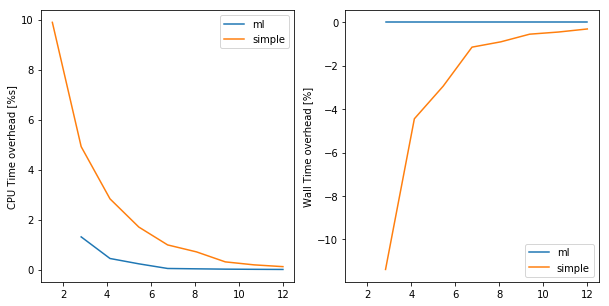

In [15]:
# medium disk
ideal_cpu = df.time.sum()
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(10, 5))
cpuplot, wallplot = axs
for name, group in visdata.groupby('method'):
    cpuplot.plot(group.limit/60/60, ((group.cputime/ideal_cpu)-1)*100, label=name)
relative = visdata.pivot(columns='method', index='limit', values='walltime').reset_index()
for method in sorted(methods.keys()):
    wallplot.plot(relative.limit/60/60, ((relative[method] / relative['ml'])-1)*100, label=method)
cpuplot.legend()
wallplot.legend()
wallplot.set_ylabel('Wall Time overhead [%]')
cpuplot.set_ylabel('CPU Time overhead [%s]')

### Parallel workers

In [16]:
class Worker(object):
    """ One allocatable performing one job."""
    def __init__(self, limit, fallback, diskMBps, jobQTime, jobOverhead, decider):
        self._cputime = 0
        self._walltime = 0
        self._limit = limit
        self._fallback = fallback
        self._disk = diskMBps
        self._jobQ = jobQTime
        self._jobS = jobOverhead
        self._decider = decider
    
    def next_molecule_at(self):
        return self._walltime + self._cputime
    
    @staticmethod
    def simple(gostep, queue, remaining, attempt):
        if attempt == 1:
            return queue
        if attempt == 2:
            return queue
        if attempt == 3:
            return 'long'
    
    @staticmethod
    def ml(gostep, queue, remaining, attempt):
        if gostep.n == 1:
            if gostep.step1 > remaining:
                return 'long'
            else:
                if attempt == 1:
                    return queue
                else:
                    return 'long'
        assert (gostep.n != 1)
        
        if gostep.step2 > remaining:
            if attempt == 1:
                return 'restart'
            else:
                return 'long'
        else:
            return queue
    
    def _place_step(self, gostep, remaining, queue, restart, attempt):
        planned_on = self._decider(gostep, queue, remaining, attempt)
        
        if planned_on == 'restart':
            restart = True
            planned_on = queue

        if planned_on != queue:
            # decider wants to upgrade
            restart = True

        if restart:
            # start a new job with this step
            restart = False
            self._walltime += self._jobQ
            self._cputime += self._jobS

            # IO component of restart
            readwfntime = 0
            if gostep.n != 1:
                readwfntime = gostep.fsize / self._disk
                self._cputime += readwfntime

            queue = planned_on
            if queue == 'short':
                remaining = self._limit
            else:
                remaining = self._fallback
            remaining -= readwfntime

        if gostep.time < remaining:
            remaining -= gostep.time
            self._cputime += gostep.time
            return True, remaining, queue, restart
        else:
            self._cputime += remaining
            remaining = 0
            restart = True
            return False, remaining, queue, restart
    
    def start_molecule(self, stepdata):
        restart = True
        queue = 'short'
        remaining = self._limit
        self._stepcount = 0
        for _, gostep in stepdata.iterrows():
            success, remaining, queue, restart = self._place_step(gostep, remaining, queue, restart, attempt=1)
            if not success:
                success, remaining, queue, restart = self._place_step(gostep, remaining, queue, restart, attempt=2)
            if not success:
                success, remaining, queue, restart = self._place_step(gostep, remaining, queue, restart, attempt=3)
            assert(success)
        return queue
    
    def total_cputime(self):
        return self._cputime

def do_run(hours, decider):
    workers = [Worker(hours*60*60, 24*60*60, DISK_SPEED, QUEUEING_TIME, JOB_OVERHEAD, decider) for _ in range(NUMWORKERS)]
    queues = []
    for molecule in df.case.unique():
        nextworker = min(workers, key=lambda x: x.next_molecule_at())
        queues.append(nextworker.start_molecule(df.query('case == @molecule')))
    
    #if len([_ for _ in queues if _ == 'long']) / len(queues) > 0.25:
    #    raise ValueError('Too many upgrades.')
    walltime = max([_.next_molecule_at() for _ in workers])
    cputime = sum([_.total_cputime() for _ in workers])
    return cputime, walltime, len([_ for _ in queues if _ == 'long']), len([_ for _ in queues if _ == 'short'])

In [31]:
ideal_cpu = df.time.sum()
limits = (1, 6, 12, 24)
DISK_SPEED = 1000
QUEUEING_TIME = 60*60
JOB_OVERHEAD = 30
NUMWORKERS = 10

visdata = []
methods = {'simple': Worker.simple, 'ml': Worker.ml}
for NUMWORKERS in (1, 4, 8, 16,):
    for limit in limits:
        for methodname, methodfunc in methods.items():
            try:
                q = do_run(limit, methodfunc)
            except:
                continue
            visdata.append({'method': methodname, 'cputime': q[0], 'walltime': q[1], 'limit': limit, 'longs': q[2], 'shorts': q[3], 'workers': NUMWORKERS})
visdata = pd.DataFrame(visdata)

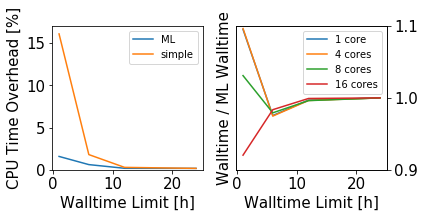

In [35]:
ideal_cpu = df.time.sum()
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(6, 3))
cpuplot, wallplot = axs
for name, group in visdata.query('workers == 4.').groupby('method'):
    cpuplot.plot(group.limit, ((group.cputime/ideal_cpu)-1)*100, label={'ml': 'ML', 'simple': 'simple'}[name])
for workers in visdata.workers.unique():
    relative = visdata.query('workers == @workers').pivot(columns='method', index='limit', values='walltime').reset_index()
    if workers > 20:
        continue
    for method in sorted(methods.keys()):
        if method == 'ml':
            continue
        if workers > 1:
            pl = 's'
        else:
            pl = ''
        wallplot.plot(relative.limit, (relative[method] / relative['ml']), label='%d core%s' % (workers, pl))
cpuplot.legend()
wallplot.legend()
wallplot.set_ylabel('Walltime / ML Walltime', fontsize=15)
cpuplot.set_ylabel('CPU Time Overhead [%]', fontsize=15)
cpuplot.set_xlabel('Walltime Limit [h]', fontsize=15)
wallplot.set_xlabel('Walltime Limit [h]', fontsize=15)
cpuplot.set_ylim(0,17)
wallplot.set_ylim(0.9,1.1)
wallplot.set_yticks([])
ax2 = wallplot.twinx()
ax2.set_ylim(0.9, 1.1)
ax2.set_yticks([0.9, 1.0, 1.1])
cpuplot.set_yticks([0, 5, 10, 15])
wallplot.tick_params('both', labelsize=15)
cpuplot.tick_params('both', labelsize=15)
ax2.tick_params('both', labelsize=15)
plt.tight_layout()
plt.savefig('gostepscheduling.pdf')

In [73]:
for name, group in visdata.query('workers == 4.').groupby('method'):
    print (name)
    print (group.cputime/ideal_cpu)

ml
9     1.015798
11    1.006143
13    1.001786
15    1.001671
Name: cputime, dtype: float64
simple
8     1.160623
10    1.017985
12    1.002869
14    1.001671
Name: cputime, dtype: float64


### scaling of estimate

In [37]:
def mlscaled(gostep, queue, remaining, attempt, scale):
    if gostep.n == 1:
        if gostep.step1*scale > remaining:
            return 'long'
        else:
            if attempt == 1:
                return queue
            else:
                return 'long'
    assert (gostep.n != 1)

    if gostep.step2*scale > remaining:
        if attempt == 1:
            return 'restart'
        else:
            return 'long'
    else:
        return queue

In [62]:
scaledata = []
NUMWORKERS = 4
for scale in np.arange(0.2, 5, 0.2):
    try:
        q = do_run(4, lambda g, q, r, a: mlscaled(g, q, r, a, scale))
    except:
        continue
    scaledata.append({'scale': scale, 'cputime': q[0], 'walltime': q[1], 'longs': q[2], 'shorts': q[3]})
scaledata = pd.DataFrame(scaledata)

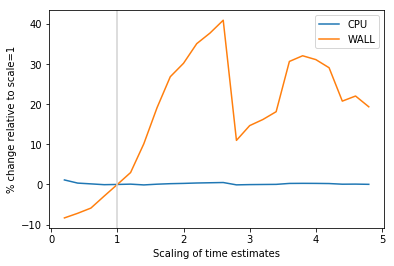

In [63]:
plt.plot(scaledata.scale, ((scaledata.cputime / scaledata.query('abs(scale-1.0) < 0.001').cputime.values[0])-1)*100, label='CPU')
plt.plot(scaledata.scale, ((scaledata.walltime / scaledata.query('abs(scale-1.0) < 0.001').walltime.values[0])-1)*100, label='WALL')
plt.axvline(x=1, color='lightgrey')
plt.xlabel('Scaling of time estimates')
plt.ylabel('% change relative to scale=1')
plt.legend()

In [54]:
scaledata.query('abs(scale-1.0) < 0.001')

,cputime,longs,scale,shorts,walltime
3,3.042116e+06,12,1.0,156,1.139225e+06
